# From Trees to Forests


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, BaggingRegressor

from sklearn import tree
#from graphviz import Source
#import graphviz
from IPython.display import Image  
#from sklearn.tree import export_graphviz
#import pydotplus
from six import StringIO  
from sklearn.inspection import permutation_importance

## Classification Tree - Titanic

Let us build a classification tree on the Titanic data using `Survived` as the outcome and `Sex, Pclass, Age, PassengerId` as explanatory variables

In [11]:
df = pd.read_csv('data/TitanicTrain.csv') # Load the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
one_hot_data = pd.get_dummies(df[["Sex", "Pclass", "Age", "PassengerId","Survived"]])
one_hot_data.head()

,Pclass,Age,PassengerId,Survived,Sex_female,Sex_male
0,3,22.0,1,0,0,1
1,1,38.0,2,1,1,0
2,3,26.0,3,1,1,0
3,1,35.0,4,1,1,0
4,3,35.0,5,0,0,1


In [5]:
train=one_hot_data[["Sex_male", "Pclass", "Age", "PassengerId","Survived"]].dropna()
X_train = train[["Sex_male", "Pclass", "Age", "PassengerId"]]
Y_train = train["Survived"]

### Shallow Tree of Depth 2

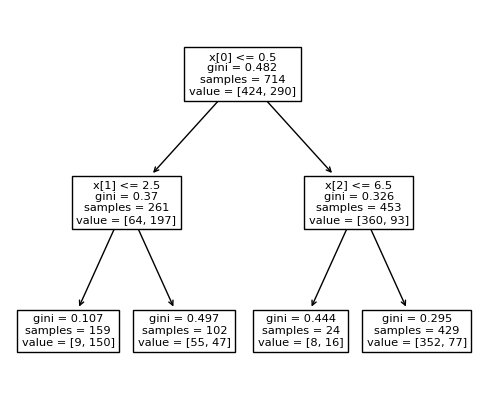

In [9]:
from sklearn import tree
plt.rcParams["figure.figsize"]=6,5

clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(X_train, Y_train)


tree.plot_tree(clf);

#### Variable Importance

In [10]:
#MDI
MDI_importances = clf.feature_importances_
indices = np.argsort(MDI_importances)
features = X_train.columns

In [12]:
#permutation importance:
MDA_importances = permutation_importance(clf, X_train, Y_train, n_repeats=5,random_state=42, n_jobs=2)
sorted_idx = MDA_importances.importances_mean.argsort()

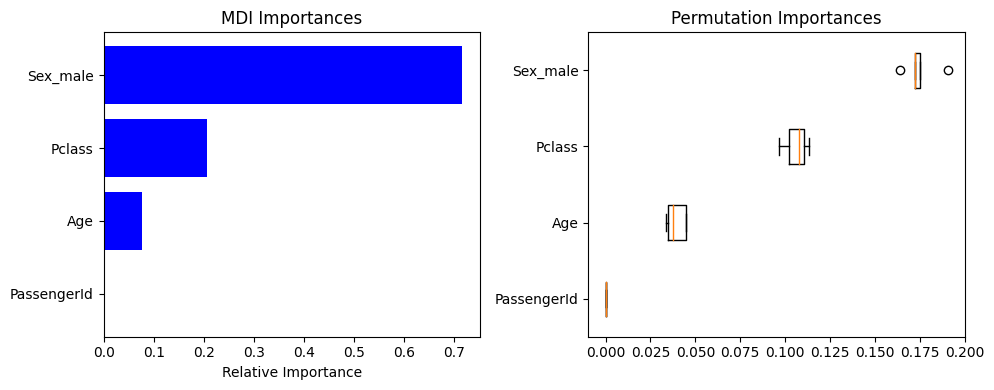

In [13]:
plt.rcParams["figure.figsize"]=10,4
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_title('MDI Importances')
ax1.barh(range(len(indices)), MDI_importances[indices], color='b', align='center')
ax1.set_yticks( np.arange(4))
ax1.set_yticklabels(features[indices])
ax1.set(xlabel='Relative Importance')


ax2.boxplot(MDA_importances.importances[sorted_idx].T,
           vert=False, labels=features[sorted_idx])
tpmp=ax2.set_title("Permutation Importances")
fig.tight_layout()


### Increasing Tree Depth 

Notice the finer and finer splits on Age and PassengerId

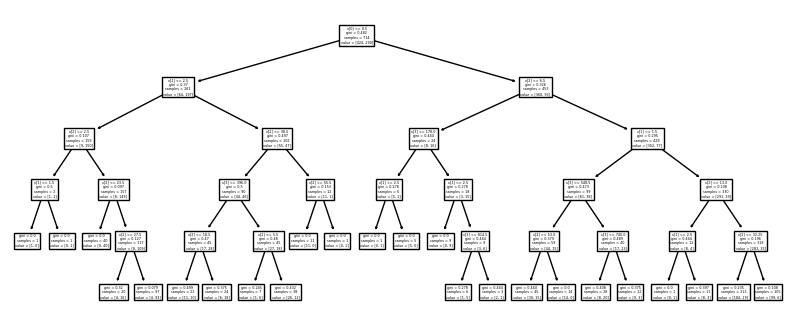

In [15]:
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(X_train, Y_train)

tmp=tree.plot_tree(clf);

#### Variable Importance

Notice that passenger ID and age are gaining MDI importance as the tree depth is increased!

In [16]:
#permutation importance:
MDA_importances = permutation_importance(clf, X_train, Y_train, n_repeats=5,random_state=42, n_jobs=2)
sorted_idx = MDA_importances.importances_mean.argsort()

#MDI
MDI_importances = clf.feature_importances_
indices = np.argsort(MDI_importances)
features = X_train.columns

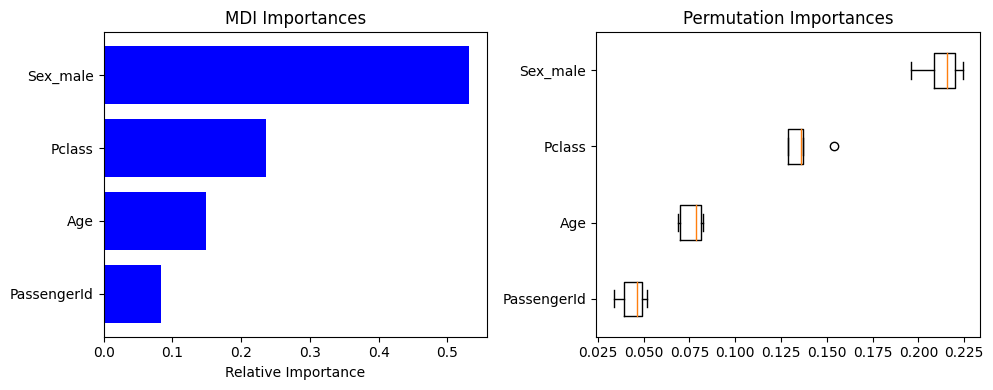

In [17]:
plt.rcParams["figure.figsize"]=10,4
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_title('MDI Importances')
ax1.barh(range(len(indices)), MDI_importances[indices], color='b', align='center')
ax1.set_yticks( np.arange(4))
ax1.set_yticklabels(features[indices])
ax1.set(xlabel='Relative Importance')


ax2.boxplot(MDA_importances.importances[sorted_idx].T,
           vert=False, labels=features[sorted_idx])
tpmp=ax2.set_title("Permutation Importances")
fig.tight_layout()


## Ensembles of Estimators

This notion—that multiple overfitting estimators can be combined to reduce the effect of this overfitting—is what underlies an ensemble method called *bagging*.
Bagging makes use of an ensemble (a grab bag, perhaps) of parallel estimators, each of which over-fits the data, and averages the results to find a better classification.
An ensemble of randomized decision trees is known as a *random forest*.

This type of bagging classification can be done manually using Scikit-Learn's ``BaggingClassifier`` meta-estimator, as shown here:

### Loading and Splitting the Dataset

In [19]:
#`load_boston` has been removed from scikit-learn since version 1.2.
#from sklearn.datasets import load_boston
import random
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report

In [22]:
#`load_boston` has been removed from scikit-learn since version 1.2.
#boston = load_boston()
url="https://raw.githubusercontent.com/markusloecher/DataScience-HWR/main/data/Boston.csv"
boston_df=pd.read_csv(url)
boston_df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [29]:
y = boston_df['medv']
X = boston_df.drop('medv',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
print(X_train.shape)
print(X_test.shape)

(354, 13)
(152, 13)


In [30]:
tree_B1 = DecisionTreeRegressor(random_state=0)
tree_B1.fit(X_train, y_train)

singleTreePreds = tree_B1.predict(X_test)
np.sqrt(mean_squared_error(y_test, singleTreePreds))

4.224170737677708

### Bagging

In [31]:
baggedBoston = BaggingRegressor(base_estimator=tree_B1,n_estimators=200,oob_score=True)

In [32]:
# The folloing line of code does all of these steps:
# It fits 200 trees on 200 bootstrapped vrsions of your training data !!
baggedBoston.fit(X_train, y_train) 

# The predict function now computes 200 predistions for each data point and averages them !!
baggedPreds = baggedBoston.predict(X_test)

np.sqrt(mean_squared_error(y_test, baggedPreds))


/Users/loecherm/.pyenv/versions/aug_hs_env/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


3.699118861118715

In [33]:
baggedBoston.oob_score_ # this is ythe equivalent of your test set loss !

0.8727022246437939

### Random Forests

In [34]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(200, max_features=0.5, oob_score=True)
forest.fit(X_train, y_train)

forestPreds = forest.predict(X_test)
np.sqrt(mean_squared_error(y_test, forestPreds))

3.4412431529172727

In [35]:
forest.oob_score_

0.8758200098217869

### Tasks

1. Find the best value for `mtry`
2. Plot the two kinds of variable importances